In [162]:
import numpy as np
from tqdm import tqdm
from src.data import *
from src.utils import *
from src.main import *

import matplotlib.pyplot as plt
from sklearn.cluster import k_means

In [163]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split

In [227]:
cfg_weak = {
    "size":1000,
    "weak_size":0.3,
    "beta":0.01,
    "gamma":0.01,
    "n_features":10,
    "n_clusters":3,
    "n_components_x":3,
    "n_components_y":4,
    "n_outputs_y":4,
    "noise_level_y":0.6,
    "repetitions":30,
}

In [228]:
tests_gaussian_singleoutput = {
    "weak":[],
    "train":[],
}

idxes_L_diag = []
k = 0
for i in range(2, cfg_weak["n_outputs_y"]+2):
    idxes_L_diag.append(k)
    k+=i
    
dictionary = tests_gaussian_singleoutput
for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )

    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*beta + 1, np.ones(X_weak.shape[0])*beta]))
    W = get_W_gaussian(X_full, normalize_W=True)

    L_full = L_full[:, idxes_L_diag]
    A_star, L_star = solve(W, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]

    L_star_single_weak = np.zeros_like(L_weak)
    L_star_single_weak[:, idxes_L_diag] = L_star_weak
    L_star_single_train = np.zeros_like(L_train)
    L_star_single_train[:, idxes_L_diag] = L_star_train
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_single_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_single_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))  
    
tests_gaussian_singleoutput = dictionary

Mean Train 1.930, Mean Weak 1.118: 100% 30/30 [00:27<00:00,  1.11it/s]


In [229]:
tests_kmeans_singleoutput = {
    "weak":[],
    "train":[],
}

idxes_L_diag = []
k = 0
for i in range(2, cfg_weak["n_outputs_y"]+2):
    idxes_L_diag.append(k)
    k+=i
    
dictionary = tests_kmeans_singleoutput
for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )

    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*beta + 1, np.ones(X_weak.shape[0])*beta]))
    W = get_W_k_means(X_full, n_clusters=cfg_weak["n_clusters"], normalize_W=True)

    L_full = L_full[:, idxes_L_diag]
    A_star, L_star = solve(W, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]

    L_star_single_weak = np.zeros_like(L_weak)
    L_star_single_weak[:, idxes_L_diag] = L_star_weak
    L_star_single_train = np.zeros_like(L_train)
    L_star_single_train[:, idxes_L_diag] = L_star_train
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_single_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_single_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))  
    
tests_kmeans_singleoutput = dictionary

Mean Train 1.928, Mean Weak 0.790: 100% 30/30 [06:45<00:00, 13.53s/it]


In [230]:
tests_kmeans_multioutput = {
    "weak":[],
    "train":[],
}

dictionary = tests_kmeans_multioutput
for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )
    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*beta + 1, np.ones(X_weak.shape[0])*beta]))
    W = get_W_k_means(X_full, n_clusters=cfg_weak["n_clusters"], normalize_W=True)
    
    A_star, L_star = solve(W, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]
    
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))
    
tests_kmeans_multioutput = dictionary

Mean Train 1.187, Mean Weak 0.107: 100% 30/30 [06:44<00:00, 13.49s/it]


In [238]:
tests_gaussian_multioutput = {
        "weak":[],
        "train":[],
    }

dictionary = tests_gaussian_multioutput
for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )
    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*beta + 1, np.ones(X_weak.shape[0])*beta]))
    W = get_W_gaussian(X_full, normalize_W=True)
    
    A_star, L_star = solve(W, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]
    
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))
    
tests_gaussian_multioutput = dictionary

Mean Train 1.195, Mean Weak 0.480: 100% 30/30 [00:18<00:00,  1.61it/s]


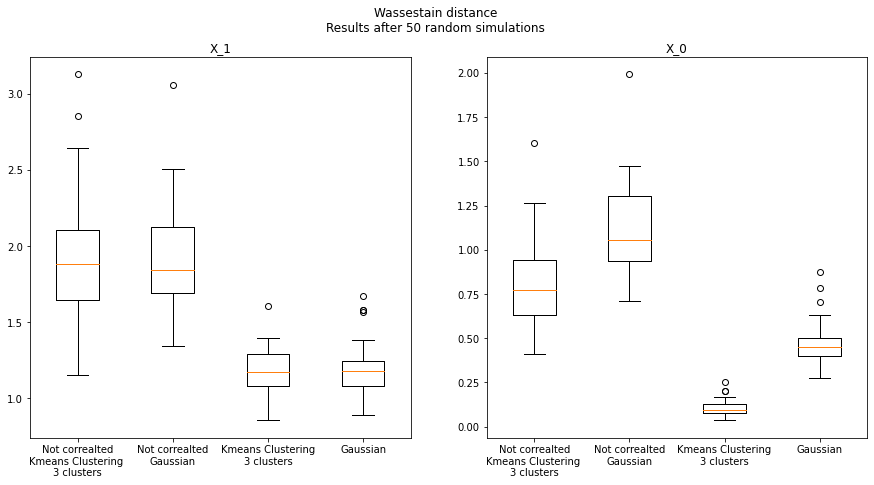

In [240]:
plt.figure(figsize=(15, 7))
plt.suptitle('Wassestain distance\nResults after 50 random simulations')
ax1 = plt.subplot(121)
ax1.set_title("X_1")
ax1.boxplot([x["train"] for x in [tests_kmeans_singleoutput, tests_gaussian_singleoutput, tests_kmeans_multioutput, tests_gaussian_multioutput]],
           labels=["Not correalted\nKmeans Clustering \n3 clusters", "Not correalted\nGaussian", "Kmeans Clustering\n3 clusters", "Gaussian"])

ax2 = plt.subplot(122)
ax2.set_title("X_0")
ax2.boxplot([x["weak"] for x in [tests_kmeans_singleoutput, tests_gaussian_singleoutput, tests_kmeans_multioutput, tests_gaussian_multioutput]],
           labels=["Not correalted\nKmeans Clustering \n3 clusters", "Not correalted\nGaussian", "Kmeans Clustering\n3 clusters", "Gaussian"])

plt.show()